In [ ]:
# check for convergence

# calculate single derivative

# calculate all derivatives for one atom

# calculate derivatives for whole molecule

In [ ]:
# check number of electrons 

In [ ]:
# error for all points?
# error as function of gpts
# energy UEG as function of boxsize/volume

In [35]:
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/hitp/')
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')

import cpmd_io
import prepare_calculations as pc

import numpy as np
import collections
import os

In [12]:
def paths2logfiles(comp, delta_lambda, lam):
    """
    prepare the run dirs for finite difference partial derivatives for small molecules
    comp: name of compound
    delta_lambda: delta for finite difference
    lam: lambda_value for which derivatives will be calculated
    """
    all_paths = [] # paths to run dirs
    # read optimized geometry and extract molecule specific parameters
    xyz_path = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/GEOMETRY.xyz'
    atom_symbols, nuc_charges, positions, valence_charges = pc.parse_xyz_for_CPMD_input(xyz_path)


    for i, atom in enumerate(atom_symbols['elIdx']):
        for fd in ['bw', 'fw']:
            path = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_{np.round(lam, 3)}/{atom}/{fd}/run.log'
            all_paths.append(path)
            # define the array of lambda values
            lambda_values = np.full_like(valence_charges, fill_value=lam, dtype='float')
            if fd == 'bw':
                lambda_values[i] -= delta_lambda
            elif fd == 'fw':
                lambda_values[i] += delta_lambda
            else:
                raise ValueError('Unknown finite difference operation')
    return(all_paths)


def check_convergence(logfile, conv_thresh):
    status = 'not converged'
    iteration_start = 0
    for i, line in enumerate(logfile):
        if 'NFI' in line:
            iteration_start = i +1
            break

    j = 0

    for line in logfile[iteration_start:]:
        line_splitted = line.split()

        try:
            gemax = float(line_splitted[1])
        except:
            gemax = conv_thresh + 10

        if gemax < conv_thresh:
            status = 'converged'
            break
    return(status)

def get_num_ve(logfile):
    ve_g = 0
    ve_r = 0
    for line in logfile:
        if "IN G-SPACE =" in line:
            ve_g = float(line.strip('\n').split()[-1])
        elif "IN R-SPACE =" in line:
            ve_r = float(line.strip('\n').split()[-1])
    
    return(ve_g, ve_r)

In [13]:
conv_thresh = 1e-6
lambda_values = np.round(np.arange(0, 1.05, 0.05), 3)
compounds = ['CH4', 'H2O','NH3', 'HF', 'ethane', 'ethene', 'ethyne', 'HCN']
status = {k:[] for k in compounds}
num_ve = {k:[] for k in compounds}
for comp in compounds:
    for lam in lambda_values:
        path = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_{lam}/run.log'
        with open(path, 'r') as f:
            logfile = f.readlines()
        status[comp].append([lam, check_convergence(logfile, conv_thresh)])
        
        ve_g, ve_r = get_num_ve(logfile)
        num_ve[comp].append([ve_g, ve_r])

In [24]:
correct_ve = []
for k in num_ve.keys():
    correct_ve.append(num_ve[k][-1][0])
    
for k, cve in zip(num_ve.keys(), correct_ve):
    for l, l1 in zip(num_ve[k], lambda_values):
        if np.isclose(l[0], cve) and np.isclose(l[1], cve):
            pass
        else:
            print(k +" " + str(l1))

ethane 0.75
ethyne 0.05
ethyne 0.15
ethyne 0.25
ethyne 0.45
ethyne 0.85
HCN 0.05
HCN 0.25
HCN 0.45
HCN 0.65
HCN 0.85


In [25]:
ethane 0.75
ethyne 0.05
ethyne 0.15
ethyne 0.25
ethyne 0.45
ethyne 0.85
HCN 0.05
HCN 0.25
HCN 0.45
HCN 0.65
HCN 0.85

6.5

In [26]:
for c, l in zip(['ethane', 'ethyne', 'ethyne', 'ethyne', 'ethyne', 'ethyne', 'HCN', 'HCN', 'HCN', 'HCN', 'HCN'],[0.75, 0.05,0.15,0.25,0.45,0.85,0.05,0.25,0.45,0.65,0.85]):
    print(f'/data/sahre/projects/finite_differences/small_molecules/{c}/lam_{l}')

/data/sahre/projects/finite_differences/small_molecules/ethane/lam_0.75
/data/sahre/projects/finite_differences/small_molecules/ethyne/lam_0.05
/data/sahre/projects/finite_differences/small_molecules/ethyne/lam_0.15
/data/sahre/projects/finite_differences/small_molecules/ethyne/lam_0.25
/data/sahre/projects/finite_differences/small_molecules/ethyne/lam_0.45
/data/sahre/projects/finite_differences/small_molecules/ethyne/lam_0.85
/data/sahre/projects/finite_differences/small_molecules/HCN/lam_0.05
/data/sahre/projects/finite_differences/small_molecules/HCN/lam_0.25
/data/sahre/projects/finite_differences/small_molecules/HCN/lam_0.45
/data/sahre/projects/finite_differences/small_molecules/HCN/lam_0.65
/data/sahre/projects/finite_differences/small_molecules/HCN/lam_0.85


In [19]:
correct_ve

[8.0, 8.0, 8.0, 8.0, 14.0, 12.0, 10.0, 10.0]

In [ ]:
correct_ve = [8,8,8,8, 'ethane', 'ethene', 'ethyne', 'HCN']

In [9]:
for k in status.keys():
    for i in status[k]:
        if i[1] == 'not converged':
            print(f'{k} {i[0]} {i[1]}')

ethene 0.45 not converged
ethyne 0.25 not converged


ethene 0.45 not converged

ethyne 0.25 not converged


In [5]:
comp = 'H2O'
delta_lambda = 5e-5
logfiles = []
for lam in np.round(np.arange(0.05, 1.05, 0.05),3):
    logfiles.extend(paths2logfiles(comp, delta_lambda, lam))
    
status = {comp:[]}#{k:[] for k in compounds}
for path in logfiles:    
    with open(path, 'r') as f:
        logfile = f.readlines()
    status[comp].append([lam, check_convergence(logfile, conv_thresh)])

In [6]:
logfiles

['/data/sahre/projects/finite_differences/small_molecules/H2O/lam_0.05/H1/bw/run.log',
 '/data/sahre/projects/finite_differences/small_molecules/H2O/lam_0.05/H1/fw/run.log',
 '/data/sahre/projects/finite_differences/small_molecules/H2O/lam_0.05/H2/bw/run.log',
 '/data/sahre/projects/finite_differences/small_molecules/H2O/lam_0.05/H2/fw/run.log',
 '/data/sahre/projects/finite_differences/small_molecules/H2O/lam_0.05/O3/bw/run.log',
 '/data/sahre/projects/finite_differences/small_molecules/H2O/lam_0.05/O3/fw/run.log',
 '/data/sahre/projects/finite_differences/small_molecules/H2O/lam_0.1/H1/bw/run.log',
 '/data/sahre/projects/finite_differences/small_molecules/H2O/lam_0.1/H1/fw/run.log',
 '/data/sahre/projects/finite_differences/small_molecules/H2O/lam_0.1/H2/bw/run.log',
 '/data/sahre/projects/finite_differences/small_molecules/H2O/lam_0.1/H2/fw/run.log',
 '/data/sahre/projects/finite_differences/small_molecules/H2O/lam_0.1/O3/bw/run.log',
 '/data/sahre/projects/finite_differences/small_

In [7]:
for k in status.keys():
    for i in status[k]:
        if i[1] == 'not converged':
            print(f'{k} {i[0]} {i[1]}')

In [29]:
def df_paths(comp, delta_lambda, lam):
    """
    prepare the run dirs for finite difference partial derivatives for small molecules
    comp: name of compound
    delta_lambda: delta for finite difference
    lam: lambda_value for which derivatives will be calculated
    """
    all_paths = [] # paths to run dirs
    # path to PP-files and type of PP (pbe)
    pp_dir = '/data/sahre/PP_LIBRARY'
    pp_type = 'GH_PBE'

    # input templates
    template_inp = '/data/sahre/projects/atomic-energies/templates_inp/cpmd_template_restart.inp'
    template_inp_small_lambda = '/data/sahre/projects/atomic-energies/templates_inp/cpmd_template_small_lambda_restart.inp'

    # read optimized geometry and extract molecule specific parameters
    xyz_path = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/GEOMETRY.xyz'
    atom_symbols, nuc_charges, positions, valence_charges = pc.parse_xyz_for_CPMD_input(xyz_path)

    # calculate correct boxsize
    num_ve = valence_charges.sum()
    reference_density = 8/(15**3) # density of UEG for a boxlength of 15 Ang and 8 valence electrons
    boxsize = (num_ve/reference_density)**(1/3)
    shift2center = True

    for i, atom in enumerate(atom_symbols['elIdx']):
        for fd in ['bw', 'fw']:
            path = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_{np.round(lam, 3)}/{atom}/{fd}'
            all_paths.append(path)
    return(all_paths)

In [41]:
base_lambda = np.arange(0.05, 1.05, 0.05)
compounds = ['CH4', 'NH3', "H2O",'HF', 'ethane', 'ethene', 'ethyne', 'HCN']
delta_lambda = 5e-5
paths = collections.defaultdict(list)
for comp in compounds:
    for lam in base_lambda:
        paths[comp].extend(df_paths(comp, delta_lambda, lam))

In [46]:
for k, nve in zip(paths.keys(),[8,8,8,8,14,12,10,10]):
    for p in paths[k]:
        logpath = os.path.join(p, 'run.log')
        if os.path.isfile(logpath):
            with open(logpath, 'r') as f:
                logfile = f.readlines()
            conv_thresh = 1e-6
            if not check_convergence(logfile, conv_thresh) == 'converged':
                print(f'Not converged {p}')
                
            g, r = get_num_ve(logfile)
            if not np.isclose(nve, g) and not np.isclose(nve,r):
                print(f'Wrong num elec {p}')
        else:
            print(f'Missing {p}')
    
        

Missing /data/sahre/projects/finite_differences/small_molecules/ethene/lam_0.45/C1/bw
Missing /data/sahre/projects/finite_differences/small_molecules/ethene/lam_0.45/C1/fw
Missing /data/sahre/projects/finite_differences/small_molecules/ethene/lam_0.45/C2/bw
Missing /data/sahre/projects/finite_differences/small_molecules/ethene/lam_0.45/C2/fw
Missing /data/sahre/projects/finite_differences/small_molecules/ethene/lam_0.45/H3/bw
Missing /data/sahre/projects/finite_differences/small_molecules/ethene/lam_0.45/H3/fw
Missing /data/sahre/projects/finite_differences/small_molecules/ethene/lam_0.45/H4/bw
Missing /data/sahre/projects/finite_differences/small_molecules/ethene/lam_0.45/H4/fw
Missing /data/sahre/projects/finite_differences/small_molecules/ethene/lam_0.45/H5/bw
Missing /data/sahre/projects/finite_differences/small_molecules/ethene/lam_0.45/H5/fw
Missing /data/sahre/projects/finite_differences/small_molecules/ethene/lam_0.45/H6/bw
Missing /data/sahre/projects/finite_differences/small_

In [8]:
from matplotlib import pyplot as plt
import scipy.interpolate as si


In [9]:
def calculate_partial_derivatives(atom, comp, delta_lambda, energy_contr, lambda_values):
    """
    prepare the run dirs for finite difference partial derivatives for small molecules
    comp: name of compound
    delta_lambda: delta for finite difference
    lam: lambda_value for which derivatives will be calculated
    """

    partial_derivatives = []

    for lam in lambda_values:
        energies = []
        for fd in ['bw', 'fw']:
            logfile_path = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_{np.round(lam, 3)}/{atom}/{fd}/run.log'
            with open(logfile_path, 'r') as f:
                logfile = f.readlines()
            # get energy
            if energy_contr == 'TOTAL ENERGY =':
                energies.append(cpmd_io.get_energy_contribution(logfile, energy_contr))
            elif energy_contr == 'ELECTRONIC ENERGY':
                
                e_el_parts = []
                for e in ['TOTAL ENERGY =','(PSEUDO CHARGE I-I) ENERGY =', 'ESR =','ESELF =']:
                    e_el_parts.append(cpmd_io.get_energy_contribution(logfile, e))
                e_nuc = e_el_parts[1]+e_el_parts[2]-e_el_parts[3]
                e_el = e_el_parts[0]-e_nuc
                energies.append(e_el)
        partial_derivatives.append((energies[1]-energies[0])/(2*delta_lambda))
    return(partial_derivatives)

In [146]:
from scipy.integrate import simpson

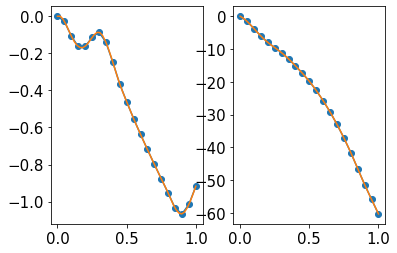

In [153]:
comp = 'HF'
delta_lambda = 5e-5

# read optimized geometry and extract molecule specific parameters
xyz_path = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/GEOMETRY.xyz'
atom_symbols, nuc_charges, positions, valence_charges = pc.parse_xyz_for_CPMD_input(xyz_path)

energy_contr = 'TOTAL ENERGY ='
e_tot_trapz = 0
e_tot_splines = 0
e_tot_simps = 0

fig, ax = plt.subplots(1,2)

for atom in atom_symbols['elIdx']:
    lambda_values = np.arange(0.05, 1.05, 0.05)
    partial_derivatives = [0.0]
    partial_derivatives.extend(calculate_partial_derivatives(atom, comp, delta_lambda, energy_contr, lambda_values))

    lambda_values = np.arange(0.0, 1.05, 0.05)
    e_tot_trapz += np.trapz(partial_derivatives, lambda_values)
    e_tot_simps += simpson(partial_derivatives, lambda_values)
    spline = si.CubicSpline(lambda_values, partial_derivatives)
    spline_lam = np.linspace(0,1, 50)
    spline_fit = spline(np.linspace(0,1, 50))
    e_tot_splines += spline.integrate(0,1)
    if 'H' in atom:
        ax[0].plot(lambda_values, partial_derivatives, '-o')
        ax[0].plot(spline_lam, spline_fit)
        #ax[0].set_xlim([0,0.5])
    else:
        ax[1].plot(lambda_values, partial_derivatives, '-o')
        ax[1].plot(spline_lam, spline_fit)

In [154]:
logfile_path1 = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_1.0/run.log'
with open(logfile_path1, 'r') as f:
    logfile1 = f.readlines()

logfile_path0 = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_0.0/run.log'
with open(logfile_path0, 'r') as f:
    logfile0 = f.readlines()

e_tot_ref = cpmd_io.get_energy_contribution(logfile1, energy_contr)-cpmd_io.get_energy_contribution(logfile0, energy_contr)

In [155]:
print(e_tot_splines-e_tot_ref)
print(e_tot_trapz-e_tot_ref)
print(e_tot_simps-e_tot_ref)

-0.03350830283958217
-0.0477095599951447
-0.03466039332776205


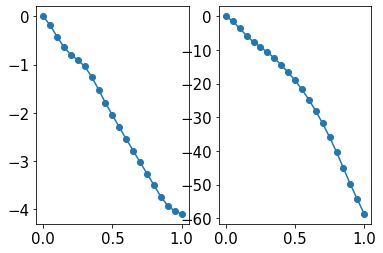

In [156]:
comp = 'HF'
delta_lambda = 5e-5
energy_contr = 'ELECTRONIC ENERGY'
e_el_trapz = 0
e_el_splines = 0
fig, ax = plt.subplots(1,2)

for atom in atom_symbols['elIdx']:
    lambda_values = np.arange(0.05, 1.05, 0.05)
    partial_derivatives = [0.0]
    partial_derivatives.extend(calculate_partial_derivatives(atom, comp, delta_lambda, energy_contr, lambda_values))

    lambda_values = np.arange(0.0, 1.05, 0.05)
    e_el_trapz += np.trapz(partial_derivatives, lambda_values)
    spline = si.CubicSpline(lambda_values, partial_derivatives)
    e_el_splines += spline.integrate(0,1)
    
    if 'H' in atom:
        ax[0].plot(lambda_values, partial_derivatives, '-o')
    else:
        ax[1].plot(lambda_values, partial_derivatives, '-o')

In [115]:
logfile_path1 = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_1.0/run.log'
with open(logfile_path1, 'r') as f:
    logfile1 = f.readlines()

logfile_path0 = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_0.0/run.log'
with open(logfile_path0, 'r') as f:
    logfile0 = f.readlines()

def get_e_el(logfile):
    e_el_parts = []
    for e in ['TOTAL ENERGY =','(PSEUDO CHARGE I-I) ENERGY =', 'ESR =','ESELF =']:
        e_el_parts.append(cpmd_io.get_energy_contribution(logfile, e))
    e_nuc = e_el_parts[1]+e_el_parts[2]-e_el_parts[3]
    e_el = e_el_parts[0]-e_nuc
    return(e_el)
    
e_el_ref = get_e_el(logfile1)-get_e_el(logfile0)

In [116]:
print(e_el_splines-e_el_ref)
print(e_el_trapz-e_el_ref)

0.005647817880809924
0.0011009899972727055


In [65]:
e_el_splines

-25.20150123110003

# UEG

In [70]:
ves = ['ve_8', 've_10', 've_12', 've_14']
boxsizes = [15, 20, 22.5, 25]
energy_ve = dict()
for ve in ves:
    energy_ve[ve] = []
    for boxsize in boxsizes:
        path_log = f'/data/sahre/projects/finite_differences/small_molecules/UEG/{ve}/a_{boxsize}/run.log'
        with open(path_log, 'r') as f:
            logfile = f.readlines()
        conv_thresh = 1e-6
        status = check_convergence(logfile, conv_thresh)
        if status == 'not converged':
            print(path_log)
        energy_ve[ve].append(cpmd_io.get_energy_contribution(logfile, 'TOTAL ENERGY ='))

14.0

Text(0, 0.5, 'E UEG (Ha)')

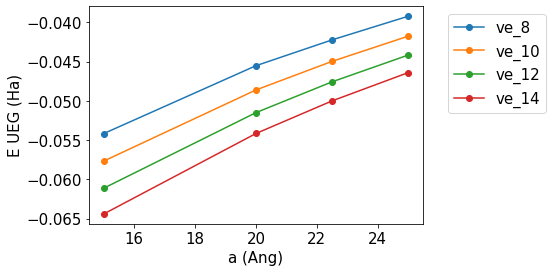

In [120]:
plt.rcParams['font.size'] = 15
for k in energy_ve.keys():
    plt.plot(boxsizes, np.array(energy_ve[k])/float(k.split('_')[1]), '-o',label = k)
plt.legend(bbox_to_anchor = (1.05,1))
plt.xlabel(r'a (Ang)')
plt.ylabel(r'E UEG (Ha)')

In [121]:
np.array(energy_ve[k])/float(k.split('_')[1])

array([-0.06441372, -0.0541697 , -0.05001709, -0.04641746])

In [126]:
-0.41775901/10 - (-0.33797308/8)



0.00047073400000000043

In [125]:
energy_ve

{'ve_8': [-0.43341627, -0.36427149, -0.33797308, -0.31388198],
 've_10': [-0.57679979, -0.48622342, -0.44983357, -0.41775901],
 've_12': [-0.73362695, -0.61814481, -0.57106732, -0.53018061],
 've_14': [-0.90179203, -0.75837586, -0.70023922, -0.64984451]}

Text(0, 0.5, 'E UEG (Ha)')

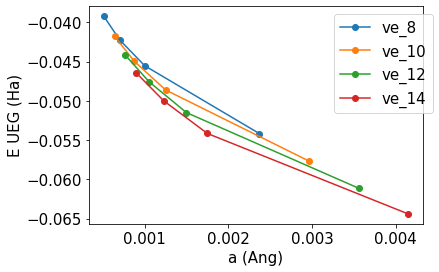

In [124]:
plt.rcParams['font.size'] = 15
for k in energy_ve.keys():
    plt.plot(float(k.split('_')[1])/np.array(boxsizes)**3, np.array(energy_ve[k])/float(k.split('_')[1]), '-o',label = k)
plt.legend(bbox_to_anchor = (1.05,1))
plt.xlabel(r'a (Ang)')
plt.ylabel(r'E UEG (Ha)')

In [127]:
0.2510038*14

3.5140532